In [95]:
import numpy as np
import pandas as pd

from sklearn.externals.six import StringIO 
from IPython.display import Image
from sklearn.impute import SimpleImputer

from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR

from sklearn.metrics import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [43]:
wine = load_wine()

In [44]:
wine_df = pd.DataFrame(data=np.c_[wine['data'], wine['target']],
                       columns=list(wine['feature_names']) + ['target'])

In [45]:
# Проверка на пропуски
wine_df.isnull().sum()

# пропусков нет, категориальный признаков тоже нет - кодировать не надо

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [46]:
wine_df.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                          float64
dtype: object

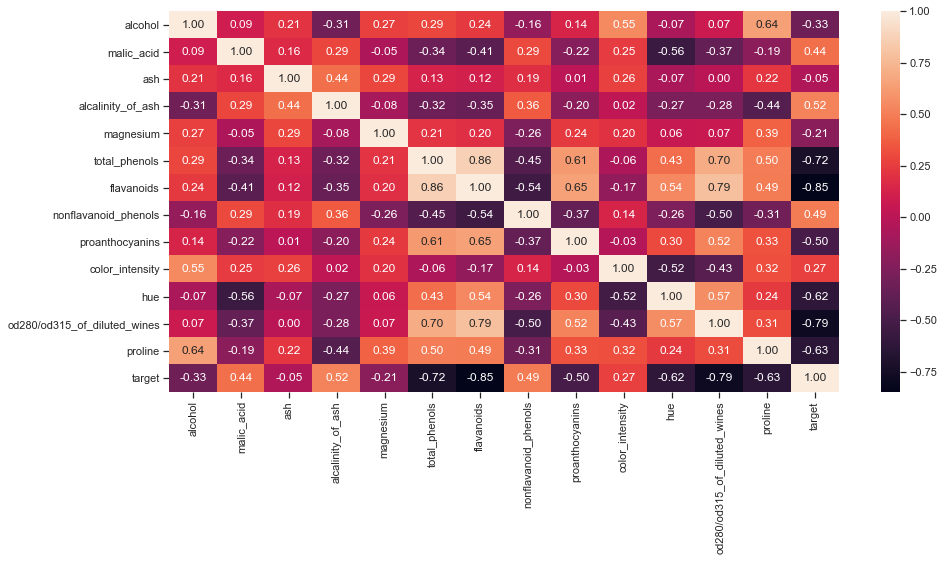

In [47]:
# Построение корреляционной матрицы
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(wine_df.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

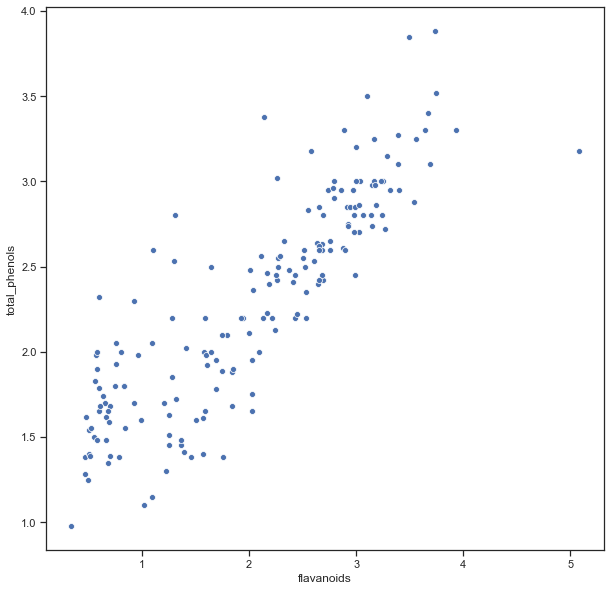

In [48]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='flavanoids', y='total_phenols', data=wine_df)

# между признаками существует зависимость близкая к линейной, коэф корреляции = 0.86 

#### Разделение на обучающую и тестовую выборки

In [49]:
X = wine_df['flavanoids'].values.reshape(-1,1)
Y = wine_df['total_phenols'].values.reshape(-1,1)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.3, random_state=1)

In [51]:
# Размер обучающей выборки
X_train.shape, Y_train.shape

((124, 1), (124, 1))

In [52]:
# Размер тестовой выборки
X_test.shape, Y_test.shape

((54, 1), (54, 1))

## Линейная модель

#### Аналитически

In [53]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [54]:
b0, b1 = analytic_regr_coef(X_train, Y_train)
b0, b1

(1.175712391016211, 0.5463301350809715)

In [55]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [56]:
y_array_regr = y_regr(X_train, b0, b1)

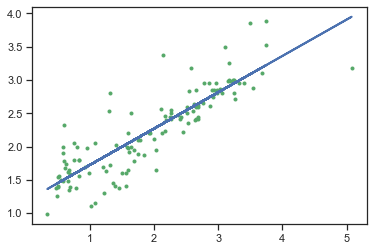

In [57]:
plt.plot(X_train, Y_train, 'g.')
plt.plot(X_train, y_array_regr, 'b', linewidth=2.0)
plt.show()

#### Использование класса LinearRegression библиотеки scikit-learn

In [62]:
# Обучение линейной регрессии и сравнение коэффициентов с рассчитанными ранее
reg1 = LinearRegression().fit(X_train, Y_train)
(b1, reg1.coef_), (b0, reg1.intercept_)

((0.5463301350809715, array([[0.54633014]])),
 (1.175712391016211, array([1.17571239])))

In [59]:
Y_pred = reg1.predict(X_test)

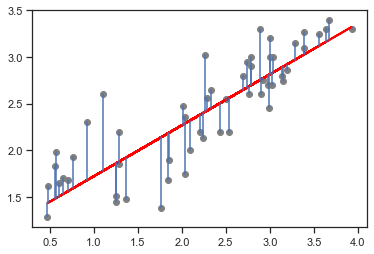

In [60]:
# Прогноз и тестовые данные, показаны ошибки между 
# истинными и предсказанными значениями

plt.scatter(X_test, Y_test,  color='gray')
plt.plot(X_test, Y_pred, color='red', linewidth=2)

for i in range(len(X_test)):
    x1 = X_test[i]
    y1 = Y_test[i]
    y2 = Y_pred[i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

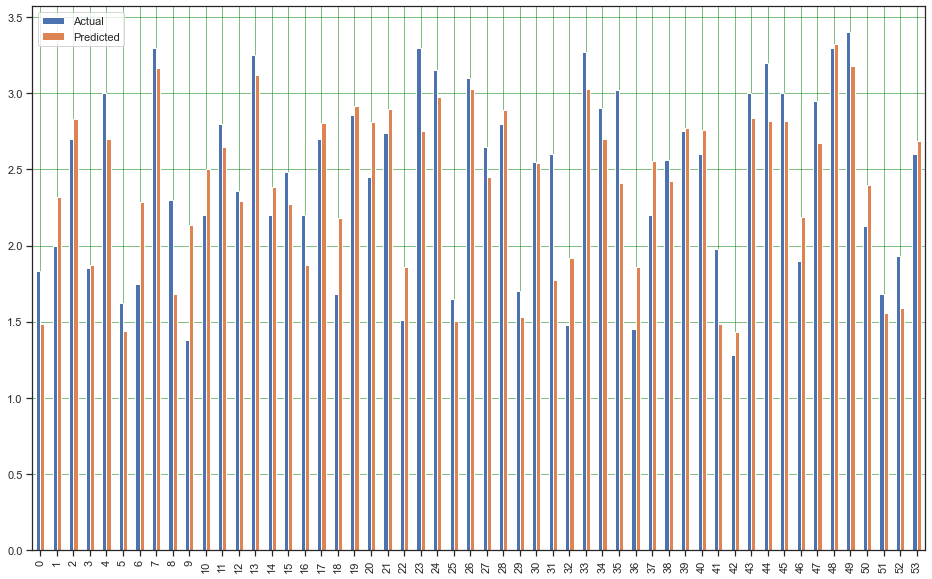

In [61]:
# Гистограмма, показывающая сравнение фактических и прогнозируемых значений

df = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})

df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [87]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[float, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [88]:
print_accuracy_score_for_classes(Y_test, Y_pred)

ValueError: If using all scalar values, you must pass an index

## SVM

In [96]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(X, Y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('flavanoids')
    ax.set_ylabel('total_phenols')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [97]:
plot_cl(LinearSVC(C=1.0, max_iter=10000))



c:\users\administrator\pycharmprojects\rk_tmm\venv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'